## Import Packages

In [1]:
import torch
import torch.utils.data
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.nn.functional import pad
from torch.nn.modules import Module
from torch.nn.modules.utils import _single, _pair, _triple
from torchvision import transforms
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import math
import time
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import os.path as osp
import os
import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import copy

## Read Pair txt file
- Here are 2 examples of the lines in the 'pairsDevTrain.txt' file:
        Abdullah_al-Attiyah	1	3
        Jean-Francois_Pontal	1	Stella_McCartney	1
        
  If there are one name and 2 figures, they are matched example, if there are 2 names, they are dismatched example.
  The image path of each person will be:
       name+ '_'+('0000'+str(j))[-4:]+'_0_align_.jpg'

- In this part, the outputs are :
        names:        a list of names of people
        img_path_list:   a list of image path of the images of each person
        label:        0 --> dismatched, 1 --> matched
        
- The output will be the input of the TestDataset function

In [2]:
def create_FaceNet_test(txt_path,img_folder):
    name_list=open(txt_path, 'r').readlines()
    name_list=[i.split() for i in name_list][1:]
    img_path_list=[]
    label=[]
    names=[]
    for i in name_list:
        if len(i)==3:
            name=i[0]           
            index1=i[1]
            index2=i[2]
            path1=os.path.join(img_folder,name+'_'+('0000'+index1)[-4:]+'_0_align_.jpg')
            path2=os.path.join(img_folder,name+'_'+('0000'+index2)[-4:]+'_0_align_.jpg')                               
            img_path_list.append([path1,path2])
            label.append(1)
            name1,name2=name,name
        elif len(i)==4:
            name1=i[0]           
            index1=i[1]
            name2=i[2]
            index2=i[3]
            path1=os.path.join(img_folder,name1+'_'+('0000'+index1)[-4:]+'_0_align_.jpg')
            path2=os.path.join(img_folder,name2+'_'+('0000'+index2)[-4:]+'_0_align_.jpg')                               
            img_path_list.append([path1,path2])
            label.append(0) 
        else:
            print('Wrong: ',i)
        names.append([name1,name2])
    
    return img_path_list,label,names
                
            

## Test Dataset

- The outputs are: 
        img1, img2, label

In [3]:
class TestDataset(Dataset):
    def __init__(self, img_path_list,label):
        self.img_path=img_path_list
        self.label=label
        
    def __getitem__(self, index):
        image_names,label=self.img_path[index],self.label[index]
        img1=Image.open(image_names[0]).resize((224,224))
        img2=Image.open(image_names[1]).resize((224,224))
        img1,img2=transforms.ToTensor()(img1),transforms.ToTensor()(img2)
        img1 = transforms.functional.normalize(img1, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        img2 = transforms.functional.normalize(img2, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        return img1,img2,label

    def __len__(self):
        return len(self.img_path)

## The FaceNet Model with ResNet 18

In [4]:
from torchvision.models import resnet18

class FaceModel(nn.Module):
    def __init__(self,embedding_size=128,pretrained=False):
        super(FaceModel, self).__init__()

        self.model = resnet18(pretrained)

        self.embedding_size = embedding_size

        self.model.fc = nn.Linear(25088, self.embedding_size)      


    def l2_norm(self,input):
        input_size = input.size()
        buffer = torch.pow(input, 2)

        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)

        _output = torch.div(input, norm.view(-1, 1).expand_as(input))

        output = _output.view(input_size)

        return output

    def forward(self, x):

        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)
        self.features = self.l2_norm(x)
        # Multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        alpha=10
        self.features = self.features*alpha
        #x = self.model.classifier(self.features)
        return self.features

## The pairwise Distance
$$ dist =\begin{Vmatrix} x_1 - x_2 \end{Vmatrix}^2_2$$


In [5]:
class PairwiseDistance(nn.Module):
    def __init__(self, p):
        super(PairwiseDistance, self).__init__()
        self.norm = p

    def forward(self, x1, x2):
        assert x1.size() == x2.size()
        eps = 1e-4 / x1.size(1)
        diff = torch.abs(x1 - x2)
        out = torch.pow(diff, self.norm).sum(dim=1)
        return torch.pow(out + eps, 1. / self.norm)

## Accuracy and ROC curve
Here shows the calculation of accuracy and ROC:
<table><tbody>
  <tr>
    <td> </td>
    <td> </td>
    <th colspan="2">  Prediction Value</th>
  </tr>
  <tr>
    <td> </td>
    <td> </td>
    <td> 1</td>
    <td > 0</td>    
  </tr>
  <tr>
  <th rowspan="2">Actual Value</th>
    <td> 1</td>
    <td>True Positive</td>
    <td>False Negative</td>
    
  </tr>
   <tr>
    <td> 0</td>
    <td>False Positive</td>
    <td>True Negative</td>
    
  </tr>
</table>

- Accuracy:
$$ Accuracy=\frac{TP+TN}{TP+TN+FP+FN}$$
- True Positive Rate （TPR):
$$ TPR=\frac{TP}{TP+FN}$$
- False Positive Rate （FPR):
$$ FPR=\frac{FP}{TN+FP}$$

In [6]:
def evaluate(distances, labels, nrof_folds=10):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 30, 0.001)
    tpr, fpr, accuracy = calculate_roc(thresholds, distances,
        labels, nrof_folds=nrof_folds)
    return tpr, fpr, accuracy

def calculate_roc(thresholds, distances, labels, nrof_folds=10):
    
    nrof_pairs = min(len(labels),len(distances))
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=True)

    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, distances[train_set], labels[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _ = calculate_accuracy(threshold, distances[test_set], labels[test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], distances[test_set], labels[test_set])
#         print(thresholds[best_threshold_index])
    tpr = np.mean(tprs,0)
    fpr = np.mean(fprs,0)
    
    return tpr, fpr, accuracy


def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc

## Make prediction 

In [7]:
def test (data_loader, model,Type):

    model.eval()
    labels, distances = [], []
    show_loss=0
    total_hard_loss=0
    hard_num=0
    for img1, img2,label in data_loader:

        img1,img2 = img1.cuda(), img2.cuda()
        img1,img2  = model(img1), model(img2)           
        
        dists = l2_dist.forward(img1,img2)   #torch.sqrt(torch.sum((out_a - out_n) ** 2, 1))  # euclidean distance
        distances.append(dists.data.cpu().numpy())
        labels.append(label)    
        
    labels = np.array([sublabel for label in labels for sublabel in label])
    distances = np.array([subdist for dist in distances for subdist in dist])
    tpr, fpr, accuracy= evaluate(distances,labels)
    acc=np.mean(accuracy)
    print('{} accuracy:  {}'.format(Type,acc))
    return tpr, fpr, acc,distances


In [8]:
BATCH_SIZE=64
NUM_WORKS=8
train_txt_path='../input/lfw-crop/pairsDevTrain.txt'
eval_txt_path='../input/lfw-crop/pairsDevTest.txt'
img_folder_path='../input/lfw-crop/LFW_cropped/LFW_cropped'
FaceNet_weight='../input/facenetweight/train_60_aug.pkl'
Timg_path_list,Tlabel,Tnames=create_FaceNet_test(train_txt_path,img_folder_path)
Eimg_path_list,Elabel,Enames=create_FaceNet_test(eval_txt_path,img_folder_path)
Train_IDS=TestDataset(Timg_path_list,Tlabel)
Eval_IDS=TestDataset(Eimg_path_list,Elabel)
train_loader=DataLoader(Train_IDS,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKS)
eval_loader=DataLoader(Eval_IDS,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKS)


In [9]:
model = FaceModel(pretrained=False).cuda()
model.load_state_dict(torch.load(FaceNet_weight))
l2_dist = PairwiseDistance(2)
Ttpr, Tfpr, Taccuracy,Tdistances=test (train_loader, model,'Train')
Etpr, Efpr, Eaccuracy,Edistances=test (eval_loader, model,'Eval')

Train accuracy:  0.8077272727272728
Eval accuracy:  0.726


## Show the ROC Curve

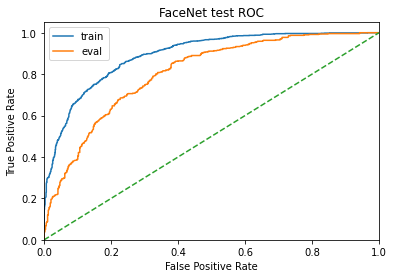

In [10]:
plt.plot(Tfpr,Ttpr,label='train')
plt.plot(Efpr,Etpr,label='eval')
plt.title('FaceNet test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

## Show the distribution of distances

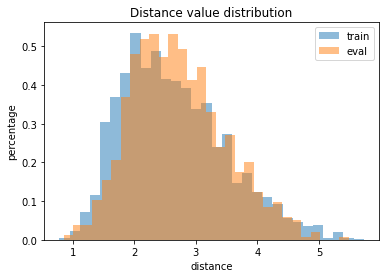

In [11]:
plt.hist(Tdistances,alpha=0.5,bins=30,density=True,label='train')
plt.hist(Edistances,alpha=0.5,bins=30,density=True,label='eval')
plt.xlabel('distance')
plt.ylabel('percentage')
plt.title('Distance value distribution')
plt.legend()
plt.show()

## Show the example images

#### Train 

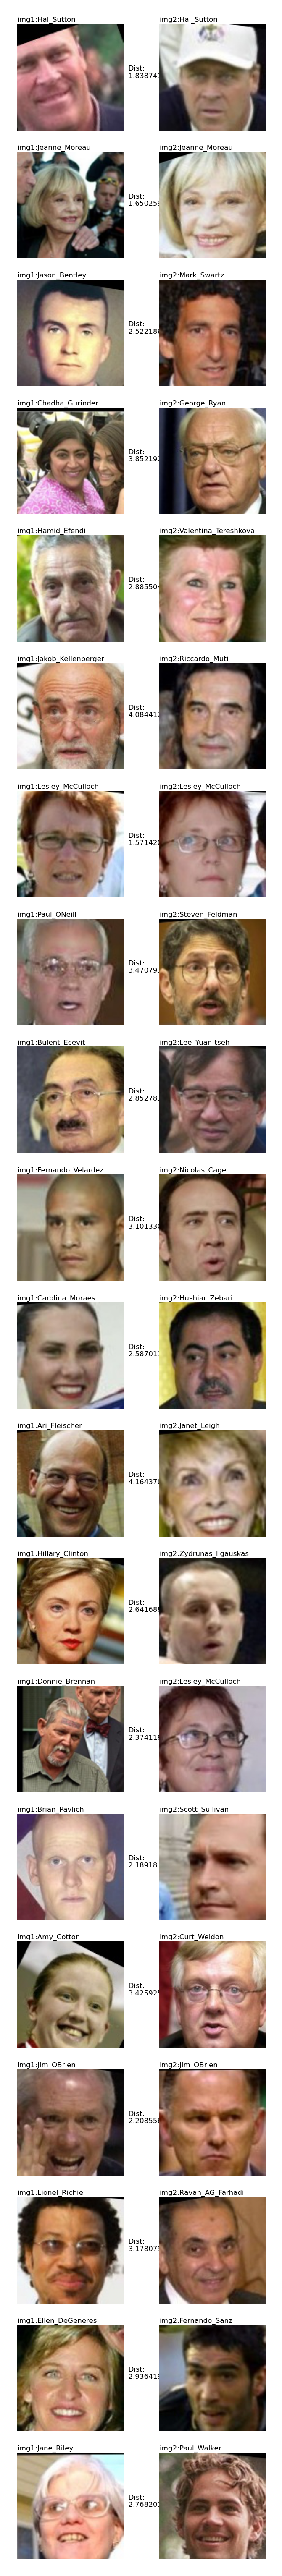

In [12]:
num_pic=20
index=np.random.randint(0,len(Timg_path_list),num_pic)
fig, ax = plt.subplots(num_pic,2,dpi = 400, figsize=(2,num_pic))
for j in range(len(index)):
    i=index[j]
    img1,img2,name1,name2=Timg_path_list[i][0],Timg_path_list[i][1],Tnames[i][0],Tnames[i][1]
    img1,img2=Image.open(img1).resize((112,112)),Image.open(img2).resize((112,112))
    ax[j,0].imshow(img1)    
    ax[j,0].text(0,-3,'img1:'+Tnames[i][0],fontsize=3)
    ax[j,0].text(112,56,'  Dist:\n  '+str(Tdistances[i]),fontsize=3)
    ax[j,1].imshow(img2)
    ax[j,1].text(0,-3,'img2:'+Tnames[i][1],fontsize=3)
for axes in ax.ravel():
    axes.axis('off')
fig.show()
fig.savefig('demo_train.png')

#### Eval

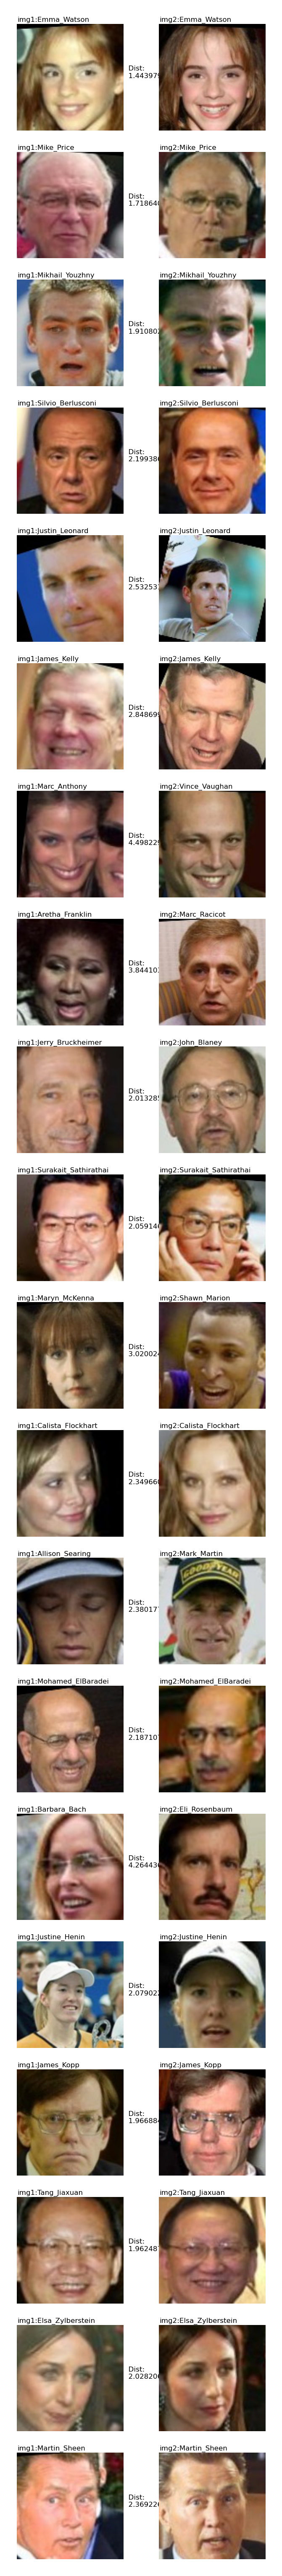

In [13]:
num_pic=20
index=np.random.randint(0,len(Eimg_path_list),num_pic)
fig, ax = plt.subplots(num_pic,2,dpi = 400, figsize=(2,num_pic))
for j in range(len(index)):
    i=index[j]
    img1,img2,name1,name2=Eimg_path_list[i][0],Eimg_path_list[i][1],Enames[i][0],Enames[i][1]
    img1,img2=Image.open(img1).resize((112,112)),Image.open(img2).resize((112,112))
    ax[j,0].imshow(img1)    
    ax[j,0].text(0,-3,'img1:'+Enames[i][0],fontsize=3)
    ax[j,0].text(112,56,'  Dist:\n  '+str(Edistances[i]),fontsize=3)
    ax[j,1].imshow(img2)
    ax[j,1].text(0,-3,'img2:'+Enames[i][1],fontsize=3)
for axes in ax.ravel():
    axes.axis('off')
fig.show()
fig.savefig('demo_eval.png')